# THREE-STAGE ENHANCEMENT OF QISKIT STANDARD TRANSPILATION

### Team LAMALAB: Aliverti-Piuri, Amadore, Concheri, Romboni, Stucchi



## Table of Contents
[Introduction](#introduction)

1. [TEMPLATES MATCHING](#chapter-1-transpiling-optimization-via-templates-matching)
    - [Idea](#1a-templates-matching)
    - [Transpilation routine](#1b-transpilation-routine)
2. [TRANSPILATION ALTERNATIVES](#chapter-2-transpilation-alternatives)
    - [ZX Calculus Simplification Strategy](#zx-calculus-simplification-strategy)
    - [Compatibility with Error Mitigation](#compatibility-with-error-mitigation)
3. [OPTIMIZING TRANSPILED CIRCUIT BY PERMUTING QUBITS IN A HARDWARE-ALLOWED FASHION](#chapter-3-optimizing-transpiled-circuit-by-permuting-qubits-in-a-hardware-allowed-fashion)
    - [Idea](#3a-the-idea)
    - [General Features](#3b-general-features-of-our-optimization-scheme)
    - [Optimization scheme](#3c-the-optimization-scheme)
    - [Example](#3d-example)
    - [General case](#3e-the-general-case)
    - [Application to 6-qubit circuit](#3f-application-to-6-qubit-circuit)


# INTRODUCTION

To enhance the current capabilities of the Qiskit transpiler, we developed a multi-stage optimization framework. Our approach is structured into three phases: an optimization step before the standard transpilation, a custom intermediate optimization based on ZX calculus, and an additional final one. Although we analyzed each phase independently across various circuit types, the full process can be integrated into a single, cohesive transpilation pipeline.

The first stage focuses on an initial simplification of the circuit for three-qubit gates based on templates matching. 

In the second stage, we adopted a simplification strategy based on ZX calculus as an alternative to the standard qiskit transpile optimizer and verified that it is compatible with standard error mitigation techniques.

The third stage is an additional transpilation step. There, we take the transpiled circuit and we further optimize it by permuting the qubits in a way that is both optimal with respect to the given error rates of all two-qubit gates, and allowed on hardware. For example, if the transpiled circuit simply performs an ECR gate on two qubits of the hardware, our method will select the pair of connected qubits whose corresponding ECR gate is least faulty. The method can be used to arbitrary circuits.

## Chapter 1: Transpiling Optimization via Templates Matching


The first stage focuses on improving the "init" stage of the transpiler, which typically involves unrolling custom instructions and converting the circuit to all single- and two-qubit gates. In particular, focusing on the translation of three-qubit gates into fewer qubit gates, even the optimized transpiler provided by Qiskit struggles in doing this step without increasing the circuit complexity and depth. However, restricting to circuits containing specific sequences of Toffoli and CNOT gates, we managed to significantly improve the overall transpilation for these circuits, following the original approach presented in the paper "Simplification of Toffoli Networks via Templates" https://webhome.cs.uvic.ca/~mmiller/publications/brazil03.pdf 

The templates we considered to implement in our transpilation process are the following:

![templates_paper](images/templates_paper.png)

### 1A) Templates-matching

This routine consists of three steps: <br>
(1) We convert the circuit into a list in order to easily work with it <br>
(2) We implement a searching algorithm to find the previously shown templates (3.2, 4.2, 4.3) in the circuit <br>
(3) We replace them with their corresponding simplified sequence <br>

**Circuit example** <br>
To see how our pre-transpilation process works, we consider a 6-register circuit with three-qubit Toffoli gates, containing the three specific templates we aim to simplify.

In [6]:
# Import necessary modules for this notebook
import qiskit
from qiskit import QuantumCircuit
print(qiskit.__version__)

#standard library for data manipulation
import numpy as np

#module to do mapping from circuit to string
from qiskit.qasm2 import dumps

#self-made library for template matching routine
import importlib
import templates as tm

importlib.reload(tm)

2.1.0


<module 'templates' from '/home/giorgiostucchi/qiskit-zx-transpiler/templates.py'>

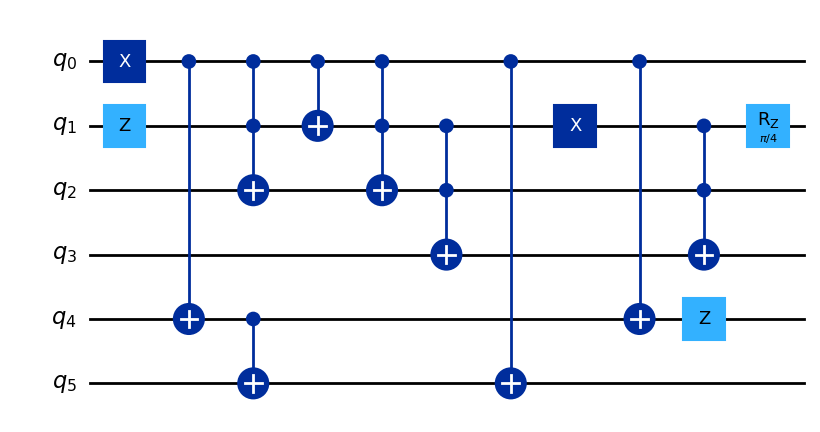

In [31]:
# we create an example of a circuit in which inside there is a template of the database

qc = QuantumCircuit(6)

qc.x(0)
# qc.ccx(4,3,1)
qc.cx(0, 4)
qc.z(1)
qc.ccx(1,0,2)
qc.cx(0, 1)
qc.ccx(0,1,2)
qc.cx(4,5)
qc.ccx(1,2,3)
qc.x(1)
qc.cx(0, 5)
qc.ccx(1, 2, 3)
qc.cx(0, 4)
qc.rz(np.pi/4, 1)
qc.z(4)


qc.draw("mpl")

**Circuit conversion** <br>
As a next step, we need to convert the circuit from Qiskit language to a more accessible format. We do it by first converting the circuit into a string using the built-in function 'dumps(circuit)', from 'qiskit.qasm2'. The string obtained is then converted into a list of lists, in which each sublist stores the information of the particular type of operation, i.e., the gate and the register qubits on which it acts. 
The list format is more accessible for us and allows us to implement a self-made search function for templates.

*Example*:<be>

| **Qiskit Circuit**                                                    | **String Format**                                                                                             | **List Format**                                    |
| --------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- | -------------------------------------------------- |
| `qc = QuantumCircuit(3)`<br>`qc.x(0)`<br>`qc.cx(0,2)`<br>`qc.ch(2,1)` | `OPENQASM 2.0;`<br>`include "qelib1.inc";`<br>`qreg q[3];`<br>`x q[0];`<br>`cx q[0],q[2];`<br>`ch q[2],q[1];` | `[['x', 0],`<br>`['cx', 0, 2],`<br>`['ch', 2, 1]]` |


In [32]:
qc_string = dumps(qc)
qc_list, qubit_num = tm.string_to_list(qc_string)

**Templates-matching routine** <br>
Now that we have the circuit in a more accessible format, we can apply our self-made function to it in order to simplify it. The idea is that there will be a search function, which will scan the entire circuit searching for specific patterns suitable for simplification. Subsequently, a different function will substitute that part of the circuit with its simplified version.
An additional function will then convert the circuit back from list format to the circuit in string format and then in Qiskit format. 

*Example*:<br>
![Template matching](images/template_matching.png)


An additional feature of the function is to recognise a specific template regardless of any possible permutation of register qubits, and in addition it is robust against the addition of unwanted in-between gates.

*Example*:<br>
![Equivalent circuit](images/equivalent_circuits.png)

In case unwanted gates interphere with the template, the template is discarded. On the other hand, if nested gates do not invalidate the template, they are ignored.

*Example*:<br>
![Nested gates](images/nested_gates.png)
 

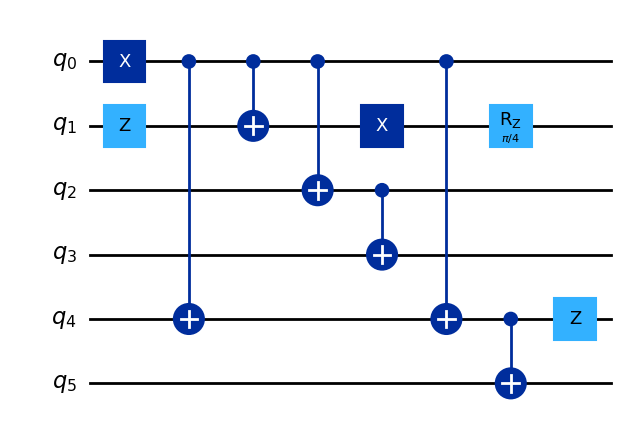

In [33]:
#matching_template is the function that takes the initial circuit and returns the new circuit after the template matching
qc_reduced = tm.matching_template(qc)
qc_reduced.draw("mpl")

### 1B) Transpilation routine

As a next step, we run the standard transpilation routine on two circuits: the raw one, and the one simplified with template-matching. 

In particular, we analyse two indicators to pinpoint the improved transpilation of the circuit: the circuit depth and the error rate.

To compare the **circuit depth**, the transpilation routine is simulated on a fake local noisy simulator as a backend (using e.g. FakeSherbrooke()), thus introducing errors into the circuit.

Optimization level: 0
Transpilation time (sec.): 0.03530073165893555
Circuit depth: 450
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.029736042022705078
Circuit depth: 246
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.034537315368652344
Circuit depth: 233
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.0597834587097168
Circuit depth: 248
------------------------------------------------------------------------------------------------------------------------------------------------------


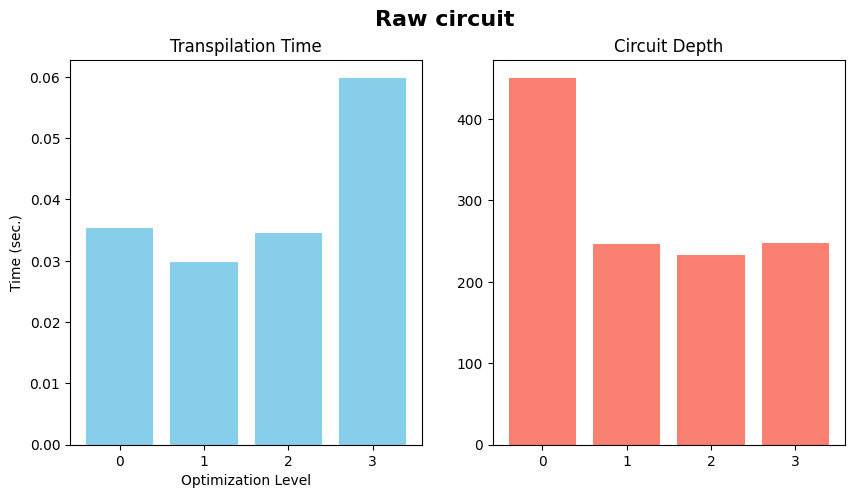

In [34]:
#Here we plot the circuit depth of the raw circuit
tm.plot_circuitdepth("FakeSherbrooke",qc, "Raw circuit")

Optimization level: 0
Transpilation time (sec.): 0.02313065528869629
Circuit depth: 107
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.023300886154174805
Circuit depth: 69
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.021021366119384766
Circuit depth: 53
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.05745816230773926
Circuit depth: 52
------------------------------------------------------------------------------------------------------------------------------------------------------


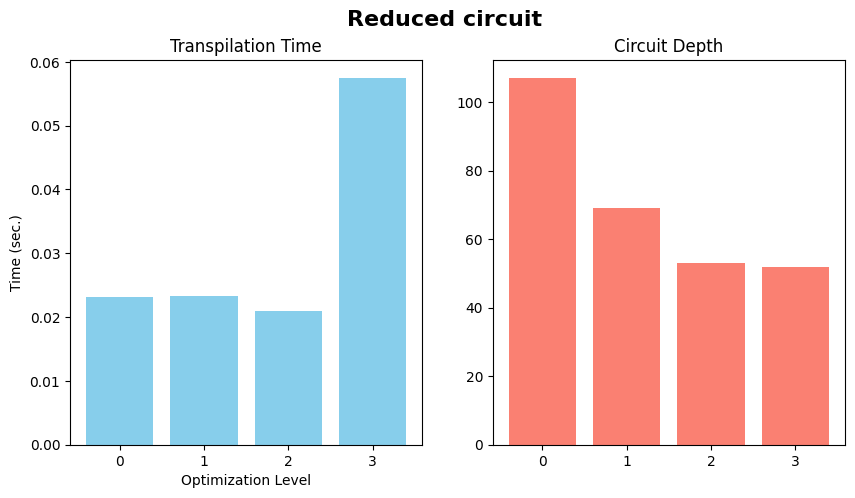

In [35]:
#Here we plot the circuit depth of the reduced circuit
tm.plot_circuitdepth("FakeSherbrooke",qc_reduced, "Reduced circuit")

As we observe, the circuit depth has significantly been reduced, i.e. 220 has been brought down to 50. This was stable for different backends and for other circuits displaying a combination of these templates, especially the Toffoli gates.

As an example of the **error** associated to the circuits, we calculate the expectation value of Z operators $\langle Z_0 Z_j \rangle \; \forall j$, for both circuits with two backends: one corresponding to a fake local simulator (as in the previous case), and one corresponding to an ideal simulation with no errors (using AerSimulator()).

In this way, we can compare how well the two circuits with error match with the ideal case.

In [36]:
operators = tm.create_operatorstring(6)


/home/giorgiostucchi/anaconda3/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
/home/giorgiostucchi/anaconda3/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
/home/giorgiostucchi/anaconda3/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


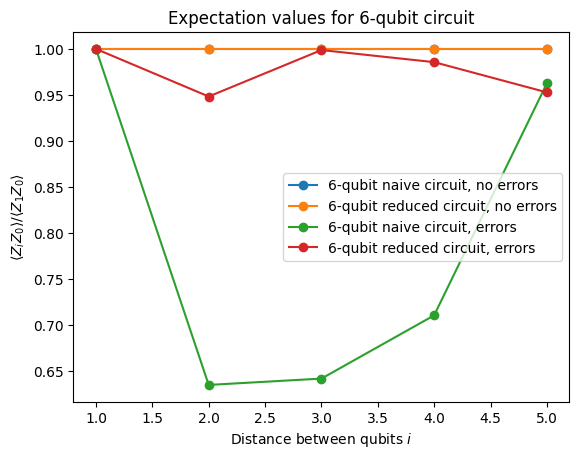

In [37]:
tm.expectation_values(operators, "FakeSherbrooke", qc, qc_reduced, 6)

As we can notice the reduced circuit with the pre-transpilation process shows an improved error suppression compared to the naive case.

# Chapter 2: TRANSPILATION ALTERNATIVES

### 2A) ZX Calculus Simplification Strategy

In [14]:
from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer
import numpy as np

import pyzx as zx
import random

from my_rem import *
from my_ddd import *
from my_lib import *

from typing import List, Callable
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit.quantum_info as qi

from mitiq.interface.mitiq_qiskit import to_qiskit
from mitiq import ddd, QPROGRAM
from mitiq.ddd import insert_ddd_sequences

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, phase_damping_error, phase_amplitude_damping_error, coherent_unitary_error

In this section, we investigate a technique to reduce the complexity of a circuit based on [ZX calculus](https://quantum-journal.org/papers/q-2020-06-04-279/). ZX calculus allows for quantum circuit optimisation by interpreting the quantum circuits as ZX-diagrams. ZX-diagrams consist of green and red nodes called spiders, which are connected by wires. Wires may curve and cross, arbitrarily many wires may connect to the same spider, and multiple wires can go between the same pair of nodes. ZX-diagrams come equipped with a set of rewrite rules, referred to as the ZX-calculus. Using these rules, circuit optimizations can be performed in the graphical language itself.

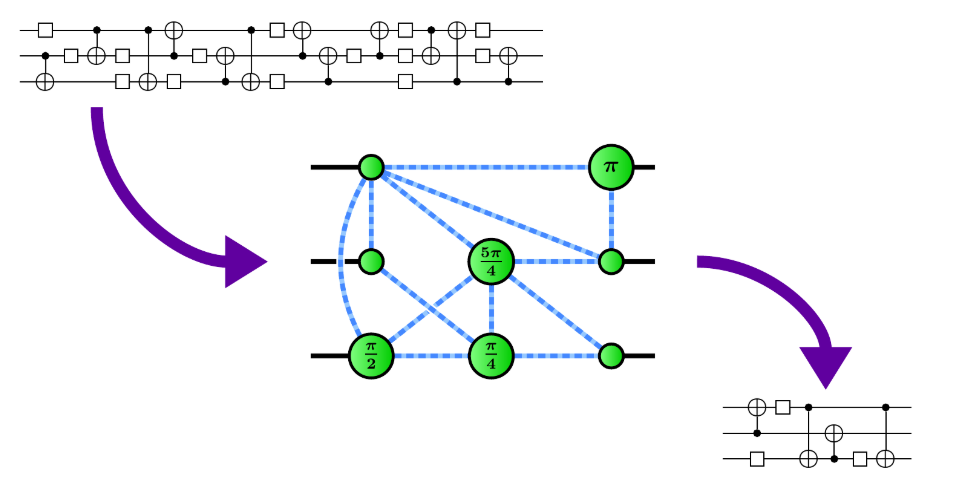

For Clifford circuits, this optimization procedure yields a new normal form that is both asymptotically optimal in size and gives a new, smaller upper bound on gate depth for nearest-neighbour architectures. We give one such example in the code.

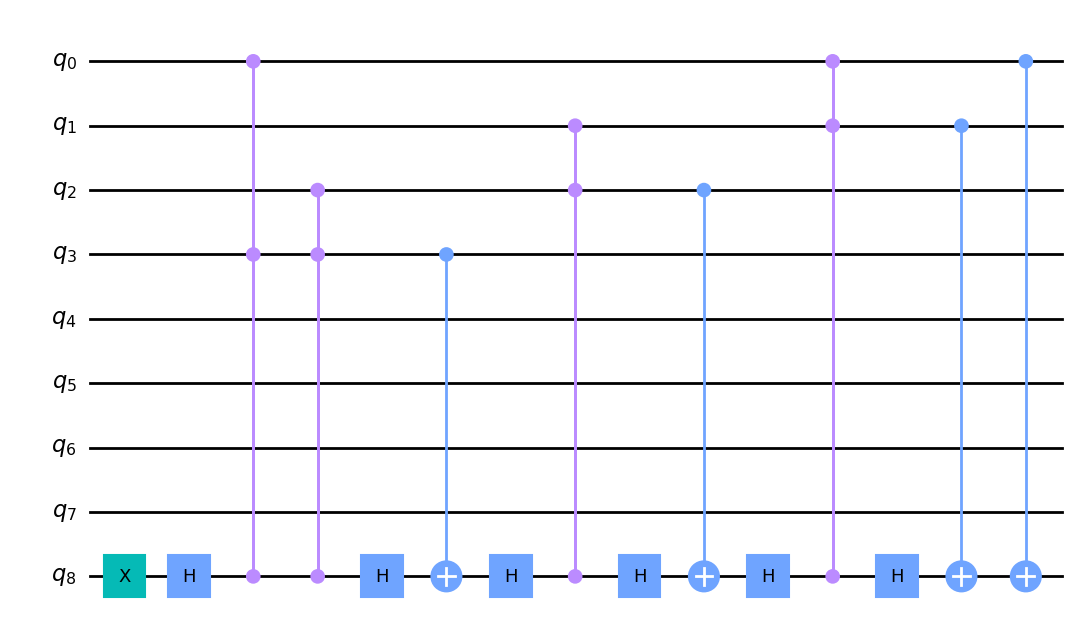

In [15]:
# Adapted from https://github.com/Quantomatic/pyzx/blob/master/circuits/Fast/mod5_4_before
qc = QuantumCircuit(9)
qc.x(8)
qc.h(8)
qc.ccz(0, 3, 8)
qc.ccz(2, 3, 8)
qc.h(8)
qc.cx(3, 8)
qc.h(8)
qc.ccz(1, 2, 8)
qc.h(8)
qc.cx(2, 8)
qc.h(8)
qc.ccz(0, 1, 8)
qc.h(8)
qc.cx(1, 8)
qc.cx(0, 8)

qc.draw(output='mpl', style='clifford')

We now process the input circuit with the custom ZX and save the updated circuit.

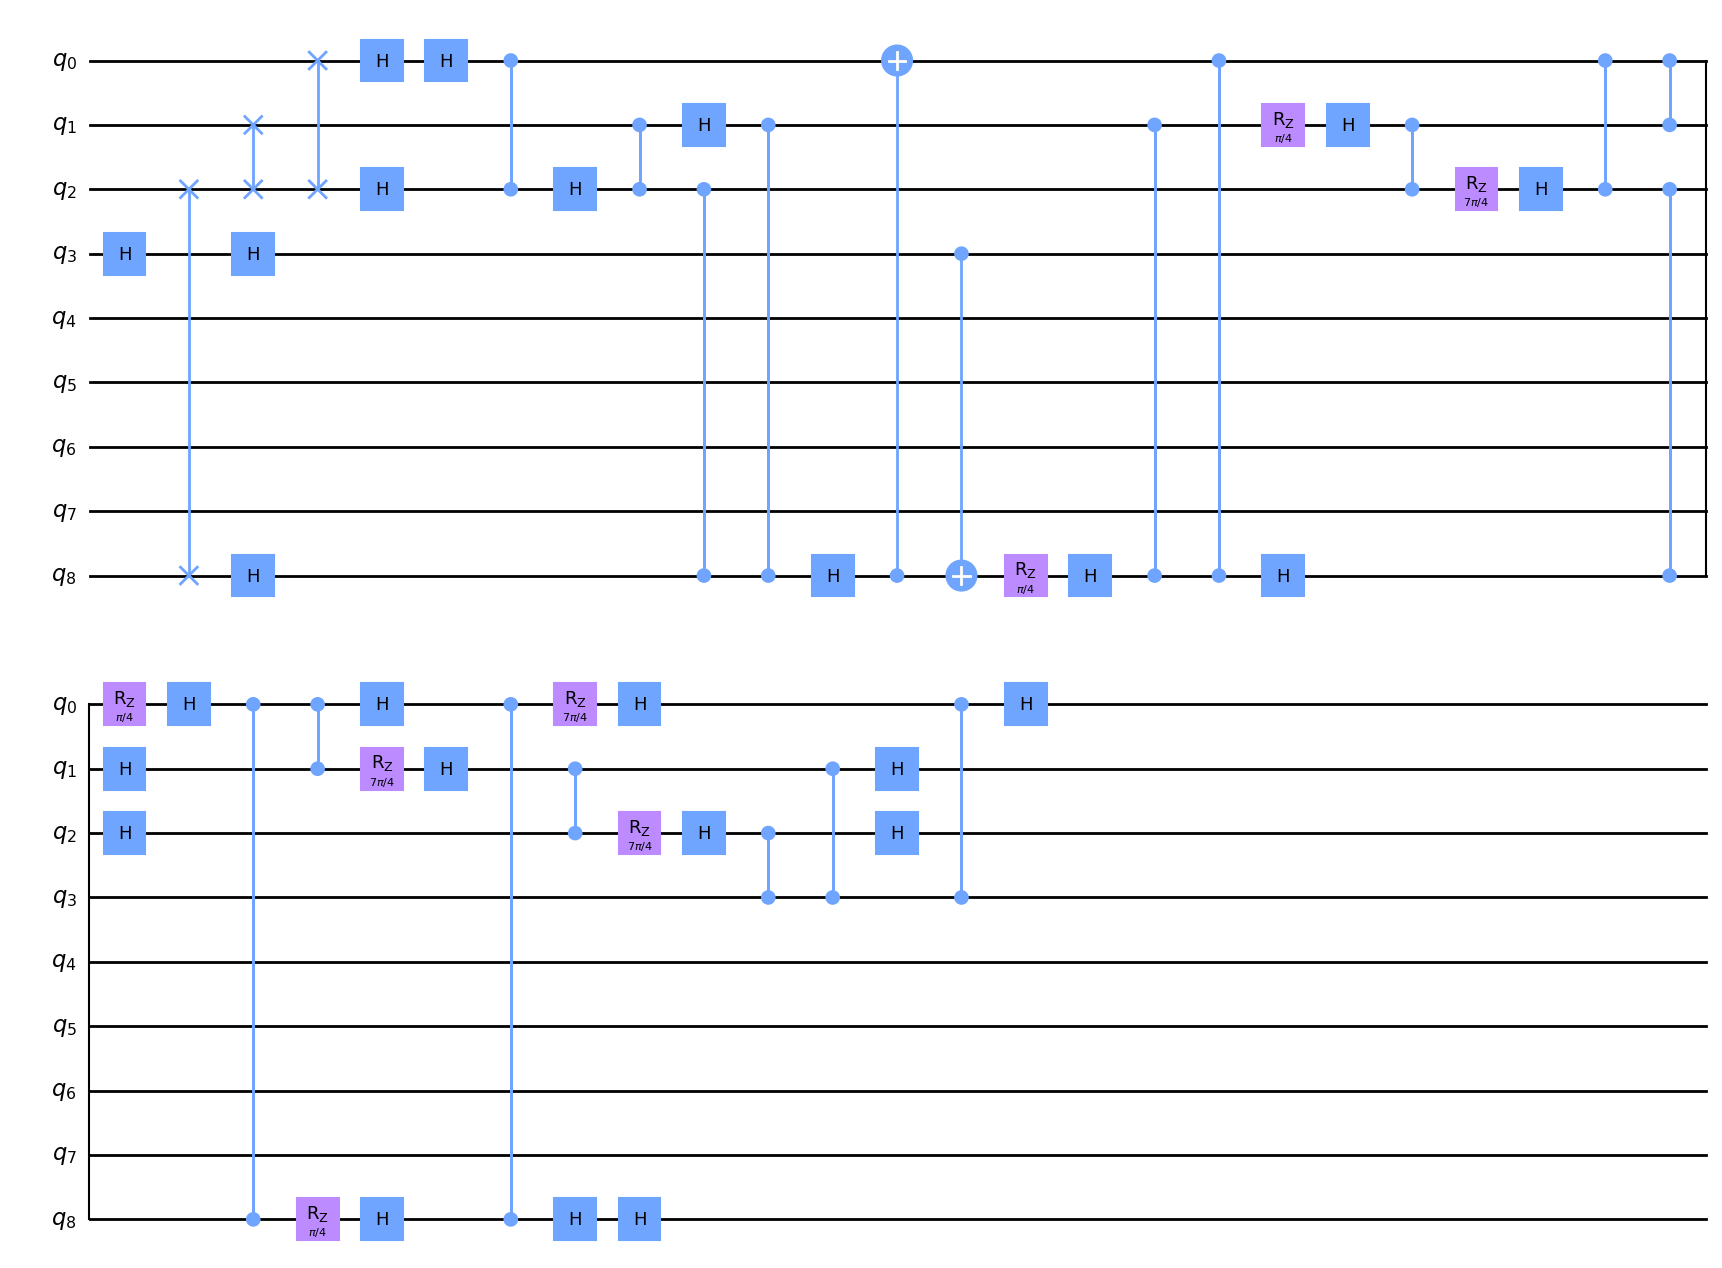

In [16]:
# taken from https://github.com/dlyongemallo/qiskit-zx-transpiler
from qiskit.transpiler import PassManager
from zxpass import ZXPass

zxpass = ZXPass()
pass_manager = PassManager(zxpass)

zx_qc = pass_manager.run(qc)
zx_qc.draw(output='mpl', style='clifford')

We also optimize the circuit with the default transpiler from qiskit in order to compare the performance (depth-wise) of the two.

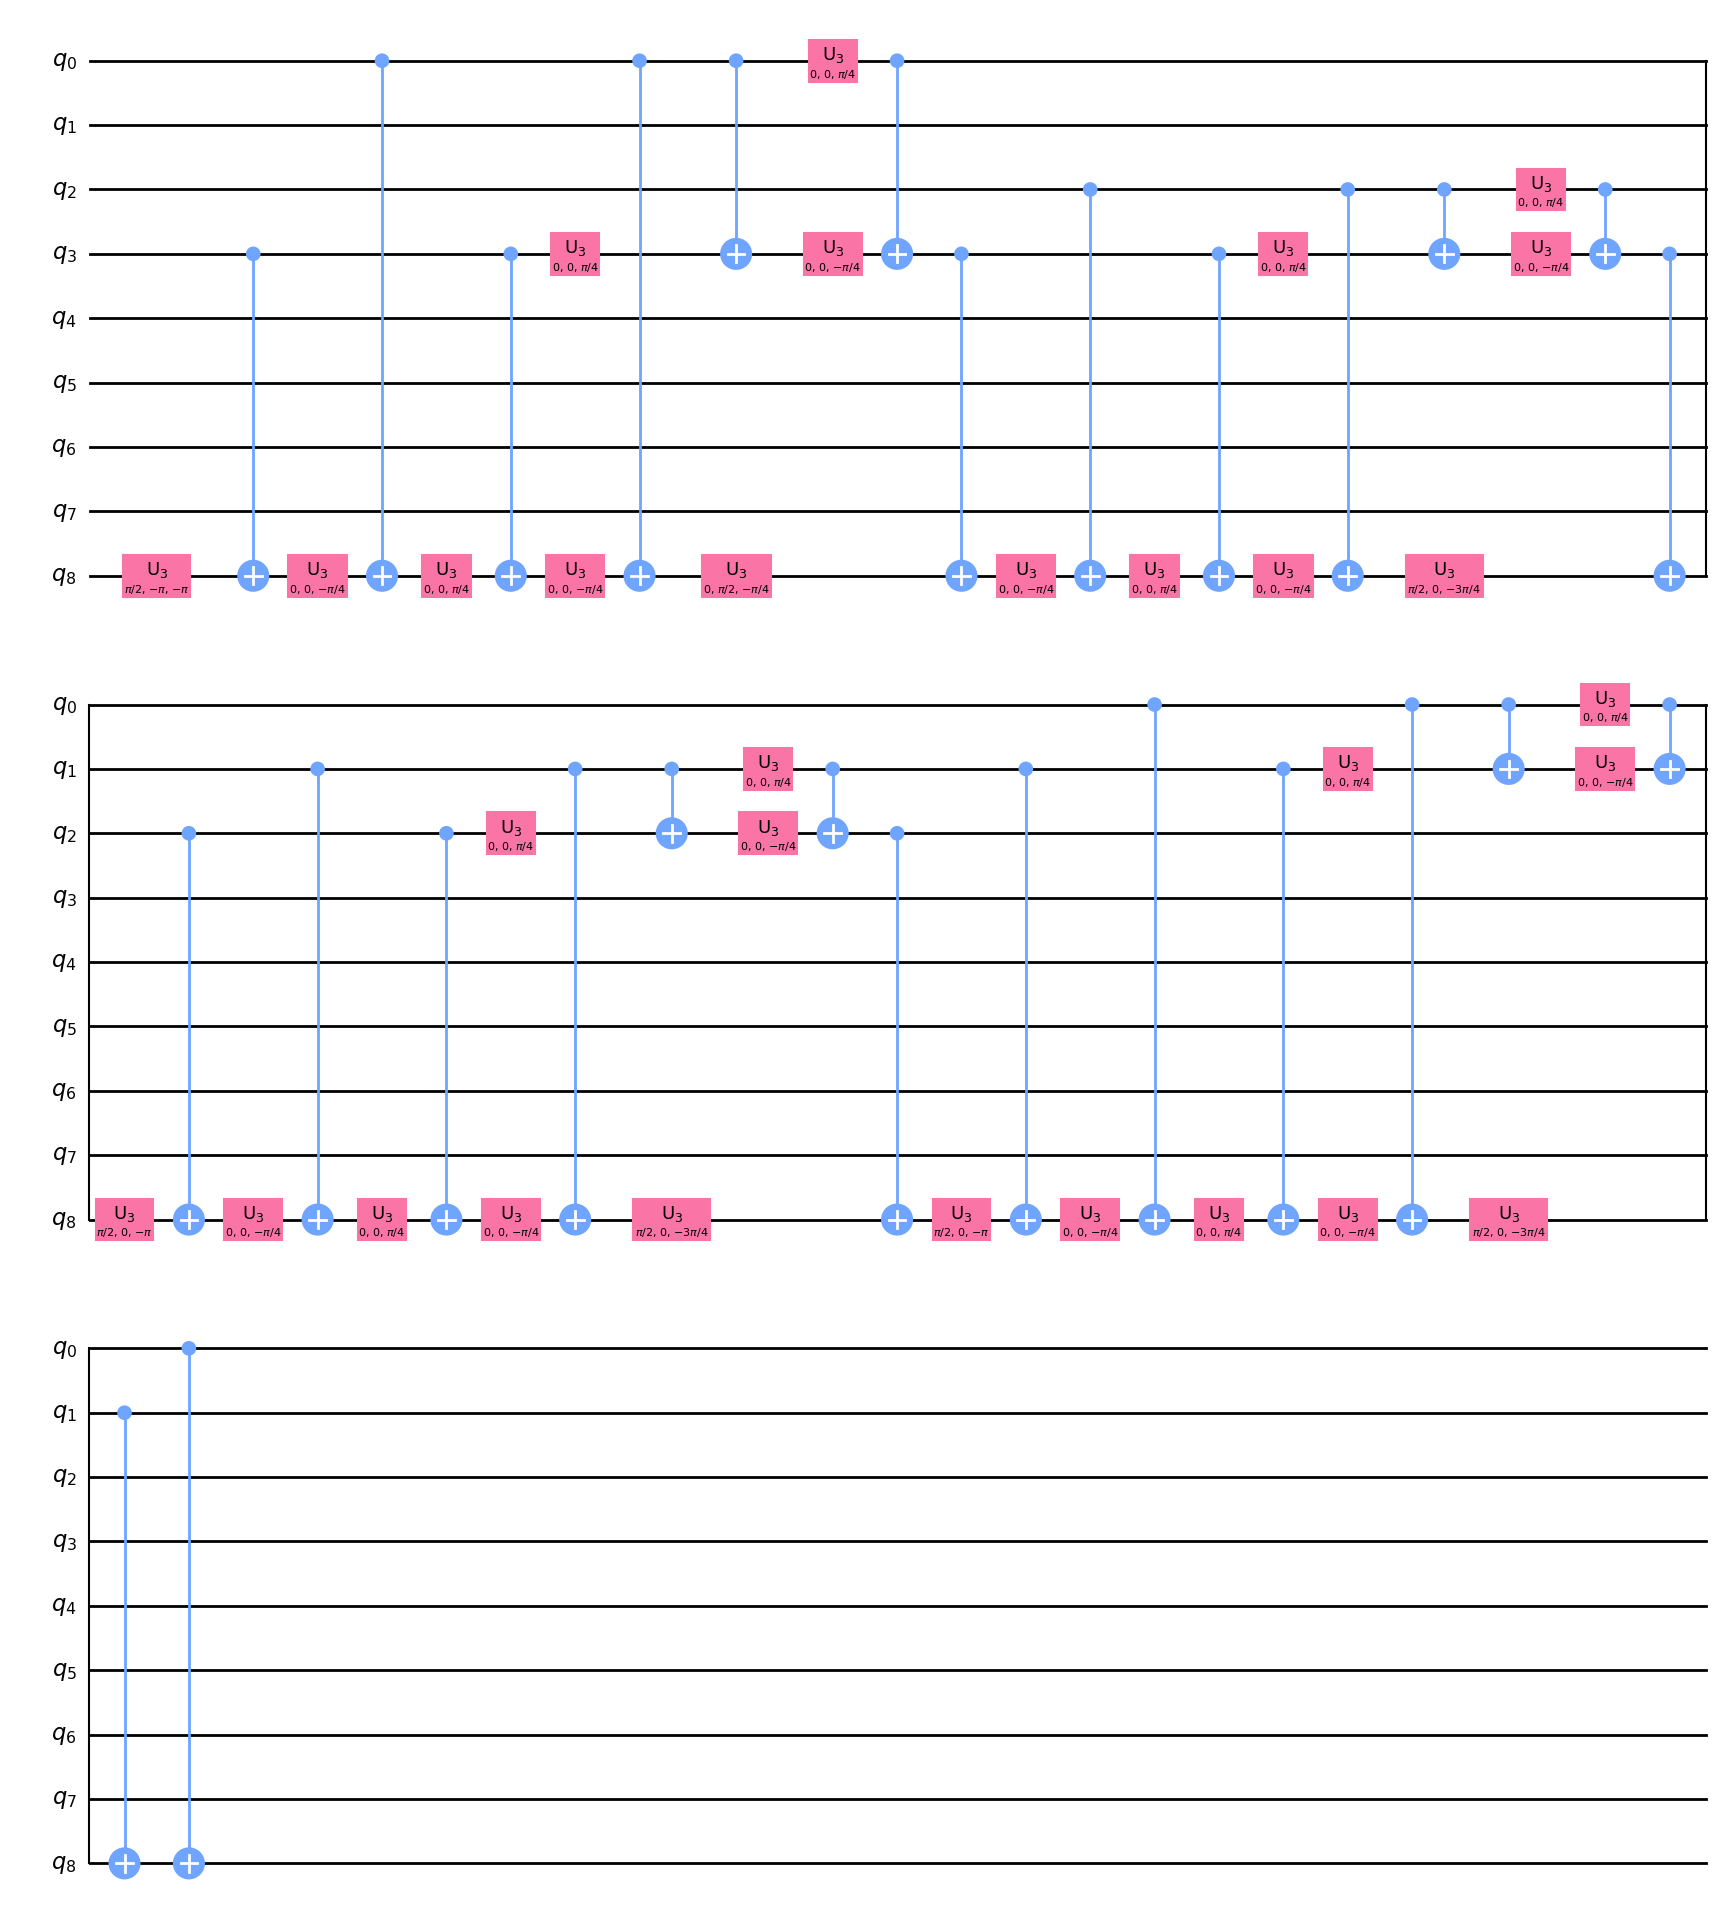

In [17]:
from qiskit import transpile
opt_qc = transpile(qc, basis_gates=['u3', 'cx'], optimization_level=3)
opt_qc.draw(output='mpl', style='clifford')

In [18]:
from qiskit.quantum_info import Statevector
print("original circuit depth: ", qc.depth())
print("transpiled circuit depth: ", opt_qc.depth())
print("PyZX circuit depth: ", zx_qc.depth())
print(Statevector.from_instruction(qc).equiv(Statevector.from_instruction(zx_qc)))

original circuit depth:  15
transpiled circuit depth:  47
PyZX circuit depth:  36
True


As can be seen, the ZX logic provides an improvement by reducing the depth of the transpiled circuit.

### 2B) Compatibility with Error Mitigation

We now verify whether we can also apply some error mitigation technique, specifically Digital Dynamic Decoupling (DDD, where sequences of gates are applied to idle windows to reduce the coupling between the qubits and the environment), alongside this ZX method. To do so, we add classical registers to be able to measure and track the evolution of the initial state. Code-wise, we use circ to define DDD rules and define an error model on all qubits with Qiskit's NoiseModel().

In [19]:
def add_measurements_to_all(circuit):
    """Adds a classical register and measures all qubits if not already present."""
    from qiskit import ClassicalRegister
    if circuit.num_clbits < circuit.num_qubits:
        creg = ClassicalRegister(circuit.num_qubits, "c")
        circuit.add_register(creg)
    for q in range(circuit.num_qubits):
        qubit = circuit.qubits[q]
        # Only add measurement if not already present for this qubit
        if not any(
            inst.operation.name == "measure" and inst.qubits[0] == qubit
            for inst in circuit.data
        ):
            circuit.measure(q, q)
    return circuit

# Apply to all relevant circuits
qc = add_measurements_to_all(qc)
opt_qc = add_measurements_to_all(opt_qc)
zx_qc = add_measurements_to_all(zx_qc)

In [20]:
import cirq

# Defining a function for the repeated ixix rule
def rep_ixix_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.I, cirq.X, cirq.I, cirq.X])

# Defining a function for the repeated xx rule
def rep_xx_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.X, cirq.X])

    # Defining a function for the repeated xx rule
def rep_yy_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.Y, cirq.Y])

In [21]:
# coherent error
err = QuantumCircuit(1, 1)
err.rx(0.2,0)
u_err = qi.Operator(err)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(u_err), ['id','y','h'])

We will now compare the average of noisy runs without mitigation with the ideal case (no noise) and with the noisy runs with mitigation applied. We first compute the respective counts, and then show them together in a histogram.

Running the circuit ... for 100000 repetitions 

{'000000000': 0.08544, '100000000': 0.91456}
Original circuit


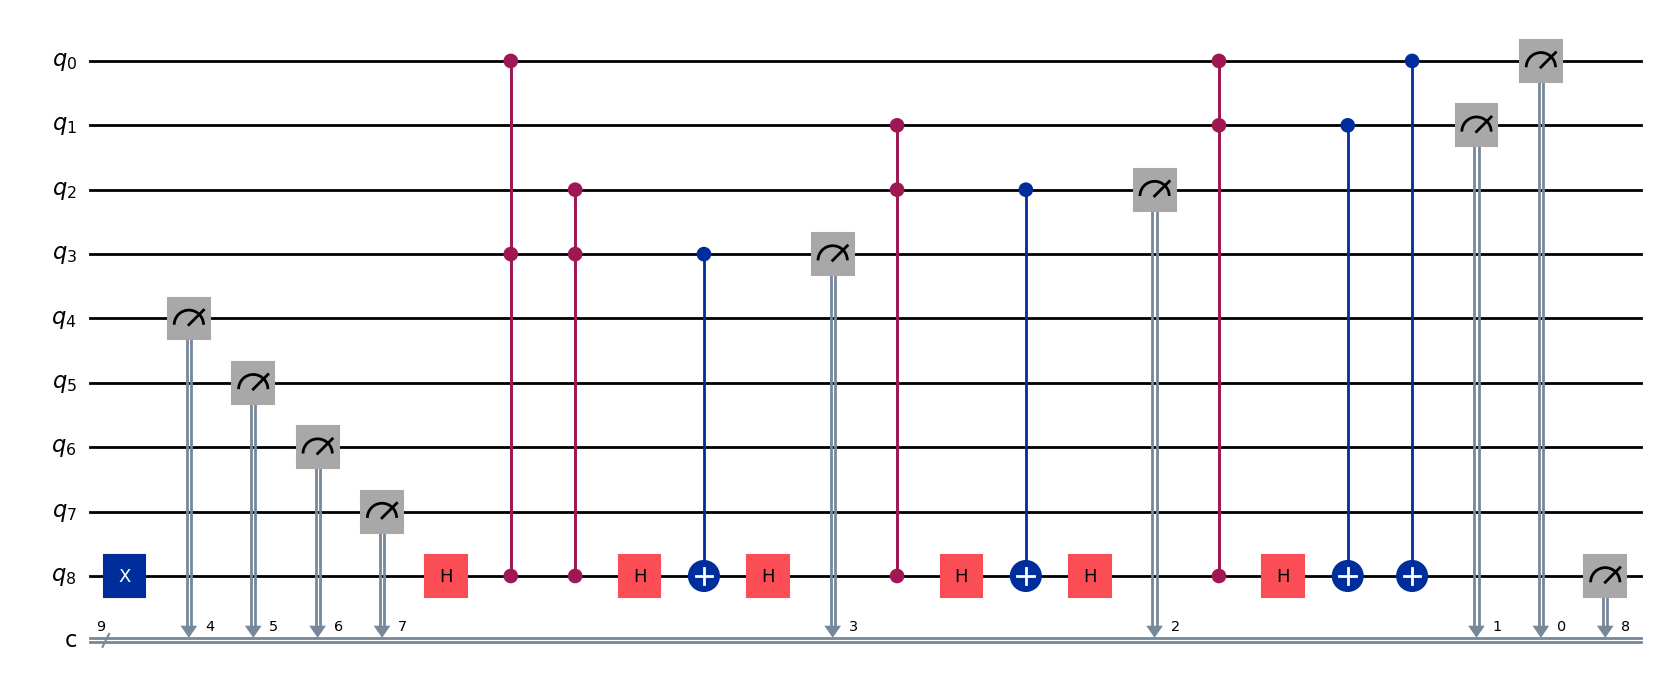

Inserting DDD sequences ... 



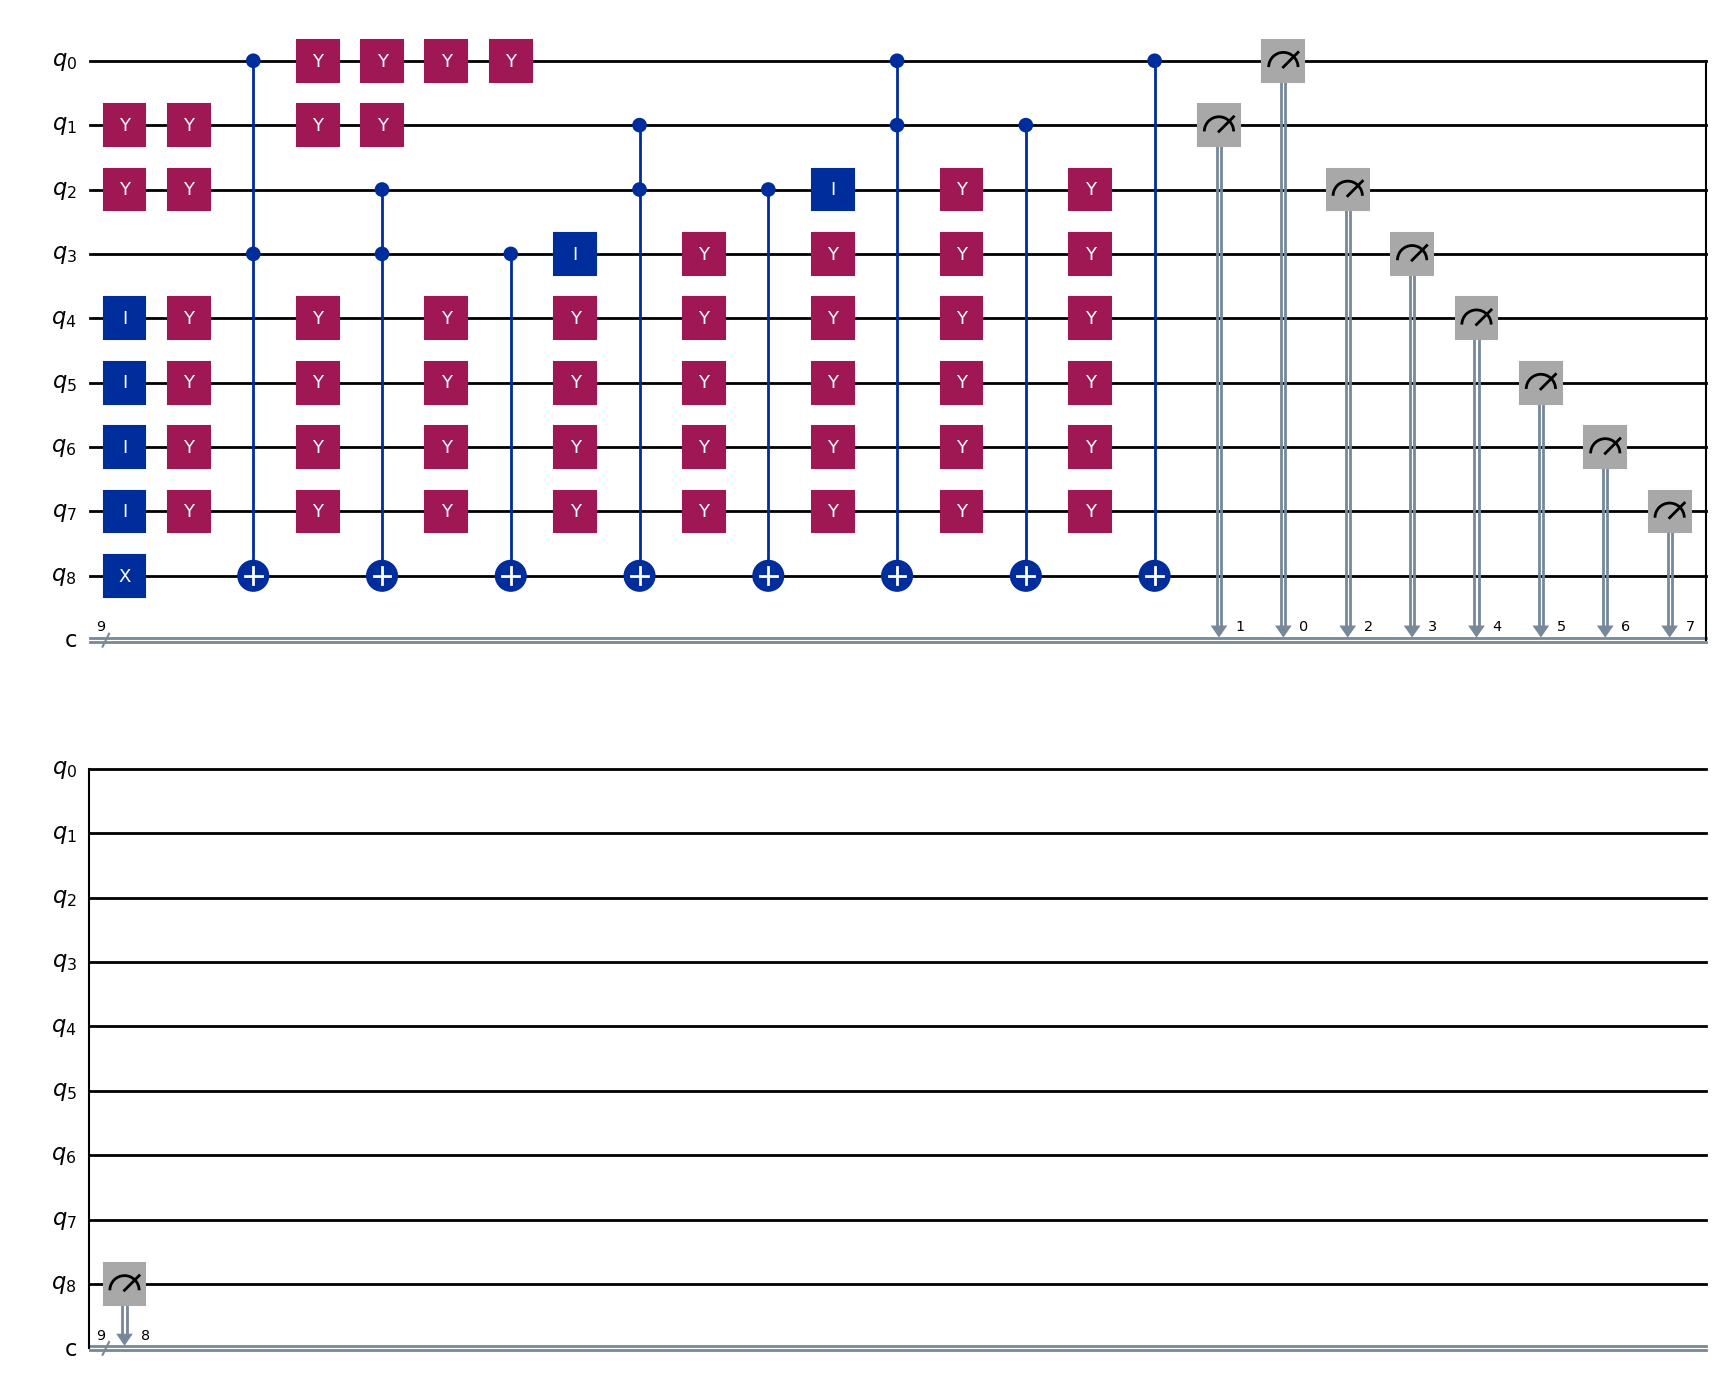

Running the circuit ... for 100000 repetitions 

{'100000000': 1.0}
Original circuit


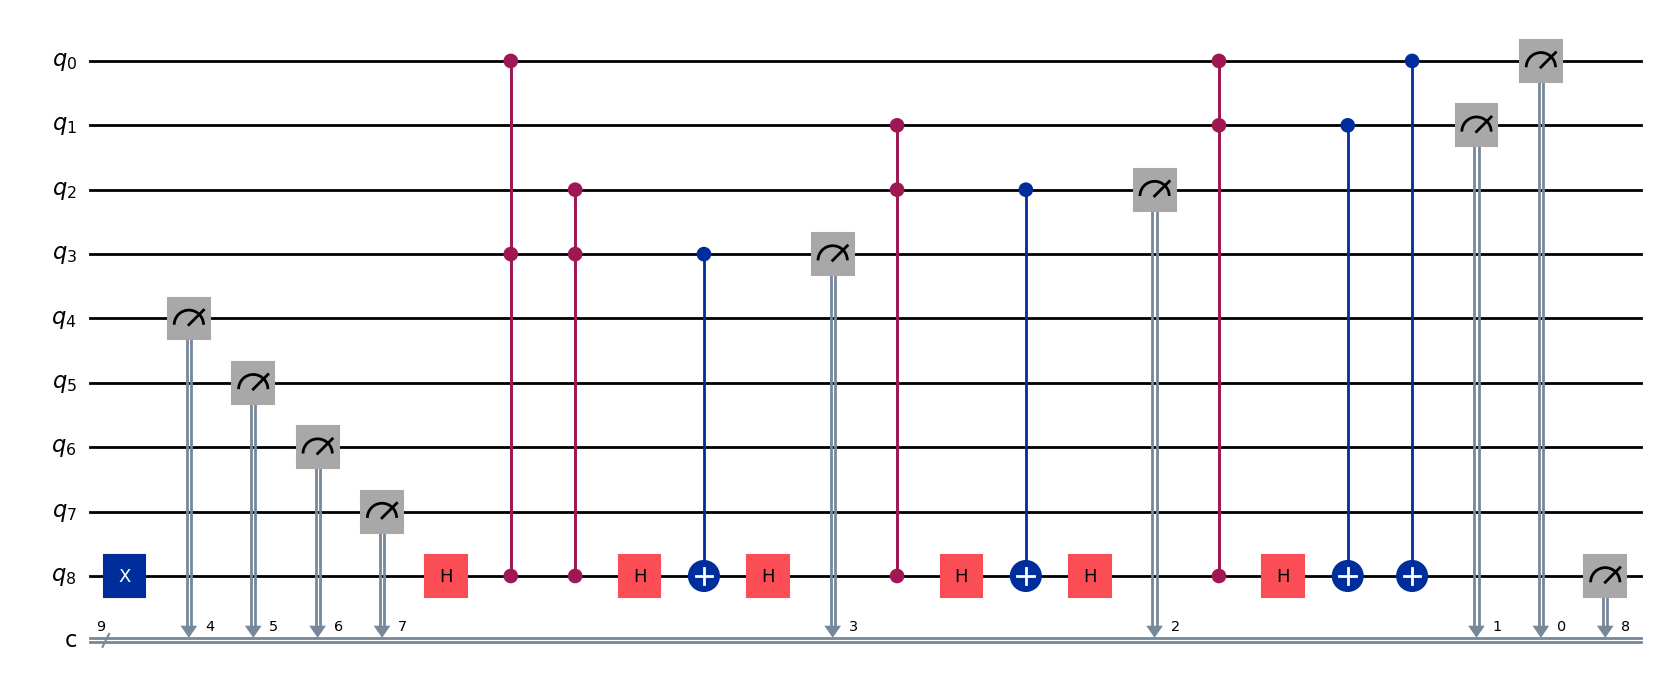

Inserting DDD sequences ... 



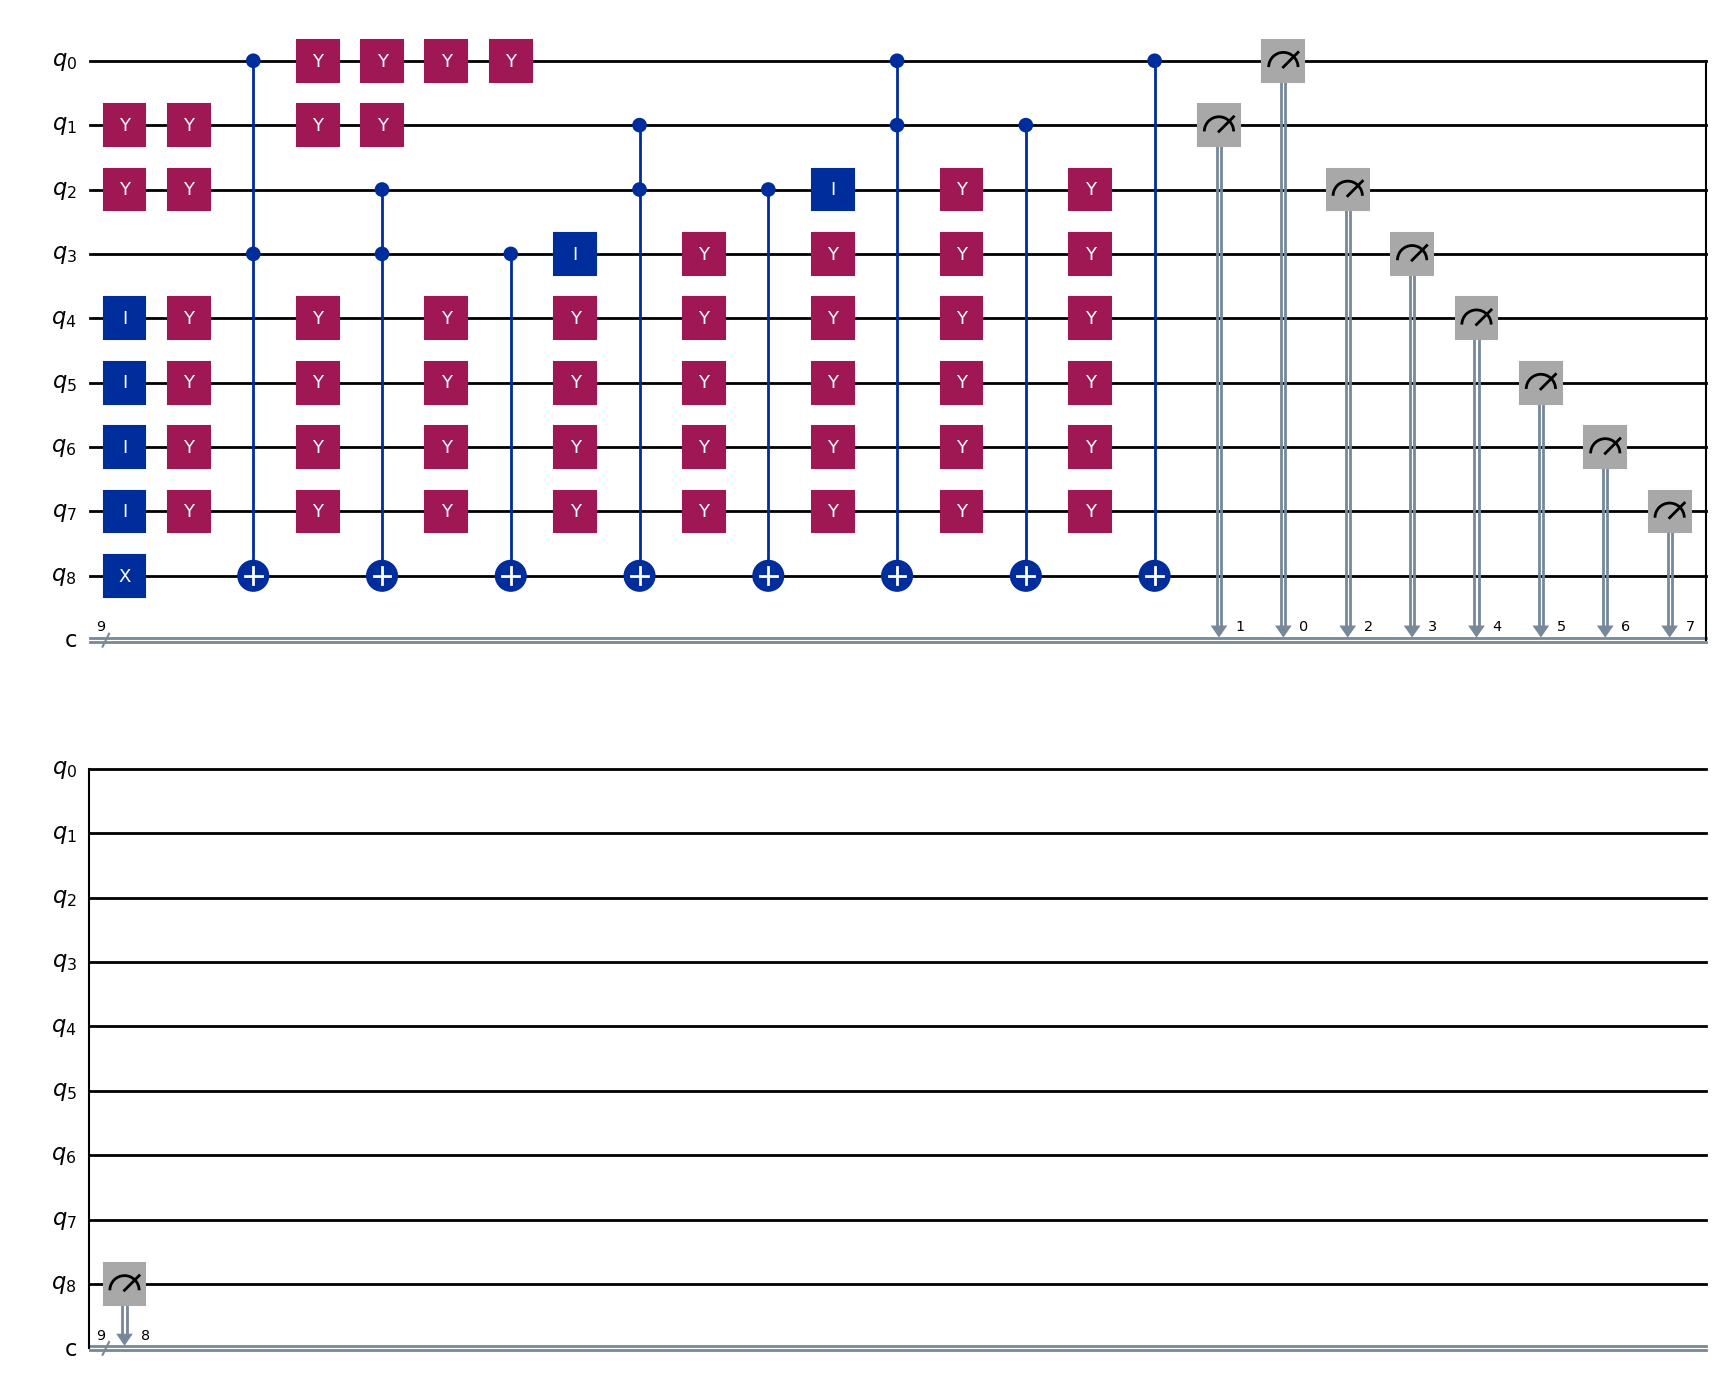

Running the circuit ... for 100000 repetitions 

{'100100100': 0.00011, '111000000': 6e-05, '110000100': 0.00012, '100010100': 7e-05, '100010000': 0.00933, '100000100': 0.00892, '100011000': 7e-05, '101100000': 0.00011, '101001000': 0.00011, '100001000': 0.00942, '100000000': 0.9429, '100100000': 0.0094, '101011000': 2e-05, '110001000': 7e-05, '100110000': 6e-05, '101000000': 0.00905, '110010000': 0.0002, '100001100': 6e-05, '110100000': 8e-05, '110000000': 0.00949, '100101000': 0.00012, '101000100': 0.00013, '101010000': 0.0001}


In [22]:
num_qubits = 9  # Number of qubits in the circuit

# Define other parameters
reps = 100000
#noise = get_combined_noise(error_meas, error_phase_amplitude_damping)
ddd_flag = True
shots = 10000
ddd_sequence = rep_yy_rule  # Use appropriate DDD sequence from mitiq

circuit = qc

# Apply DDD (if required) and run the circuit
counts = apply_ddd_and_run(
    circuit,
    noise=noise_model,
    reps=reps,
    ddd=False,
    ddd_rule=ddd_sequence,
    output=True,
    simulated_hardware=False
)

#print(counts)

total = sum(counts.values())
probabilities = {k: v / total for k, v in counts.items()}
print(probabilities)


counts_ideal = apply_ddd_and_run(
    circuit,
    noise=None,
    reps=reps,
    ddd=ddd_flag,
    ddd_rule=ddd_sequence,
    output=True,
    simulated_hardware=False
)

# Apply the mitigator (if required) to the results
total = sum(counts_ideal.values())
probabilities_ideal = {k: v / total for k, v in counts_ideal.items()}
print(probabilities_ideal)


counts_mitigated = apply_ddd_and_run(
    circuit,
    noise=noise_model,
    reps=reps,
    ddd=ddd_flag,
    ddd_rule=ddd_sequence,
    output=True,
    simulated_hardware=False
)

total = sum(counts_mitigated.values())
probabilities_mitigated = {k: v / total for k, v in counts_mitigated.items()}
print(probabilities_mitigated)


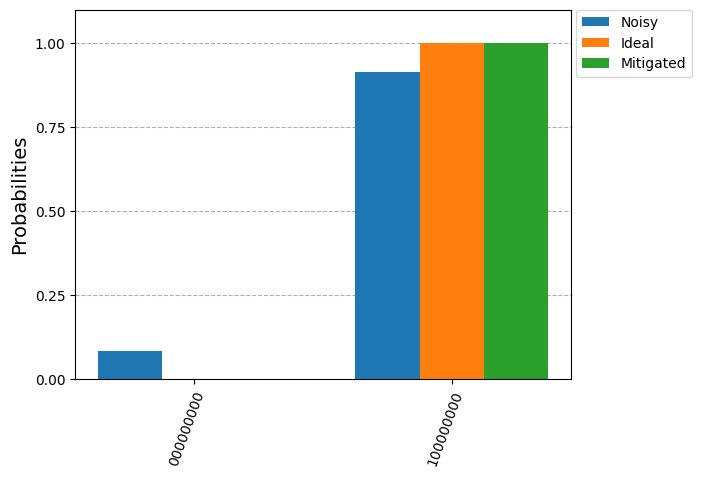

{'100000000': 0.9429}


In [23]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

labels = ['Noisy', 'Ideal', 'Mitigated']
threshold = 0.01

def filter_probs(probs, threshold):
    return {k: v for k, v in probs.items() if v >= threshold}

filtered_data = [
    filter_probs(probabilities, threshold),
    filter_probs(probabilities_ideal, threshold),
    filter_probs(probabilities_mitigated, threshold)
]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Now, use the ax parameter to specify where to plot the histogram
plot_histogram(filtered_data, legend=labels, bar_labels=False, ax=ax)
ax.set_ylabel('Probabilities')
plt.show()


print(filter_probs(probabilities_mitigated, threshold))

The histogram shows an improvement from the mitigation, as expected, showing the compatibility of the ZX logic and this basic mitigation technique.

## CHAPTER 3: OPTIMIZING TRANSPILED CIRCUIT BY PERMUTING QUBITS IN A HARDWARE-ALLOWED FASHION

### 3A) The idea ###

Given an abstract quantum circuit $C$, there are many ways to transpile, or translate, it to a quantum circuit $C_{transpiled}$ that can actually run on a given quantum computer. In particular, given one transpiled circuit $C_{transpiled}$, we have the freedom to translate or rotate (or more generally transform) the subset of qubits of the hardware that $C_{transpiled}$ employs, $C_{transpiled} \rightarrow C'_{transpiled}$.

**Example:** A translation and a rotation of an already transpiled circuit involving only 4 of the qubits of a 9-qubit quantum computer.

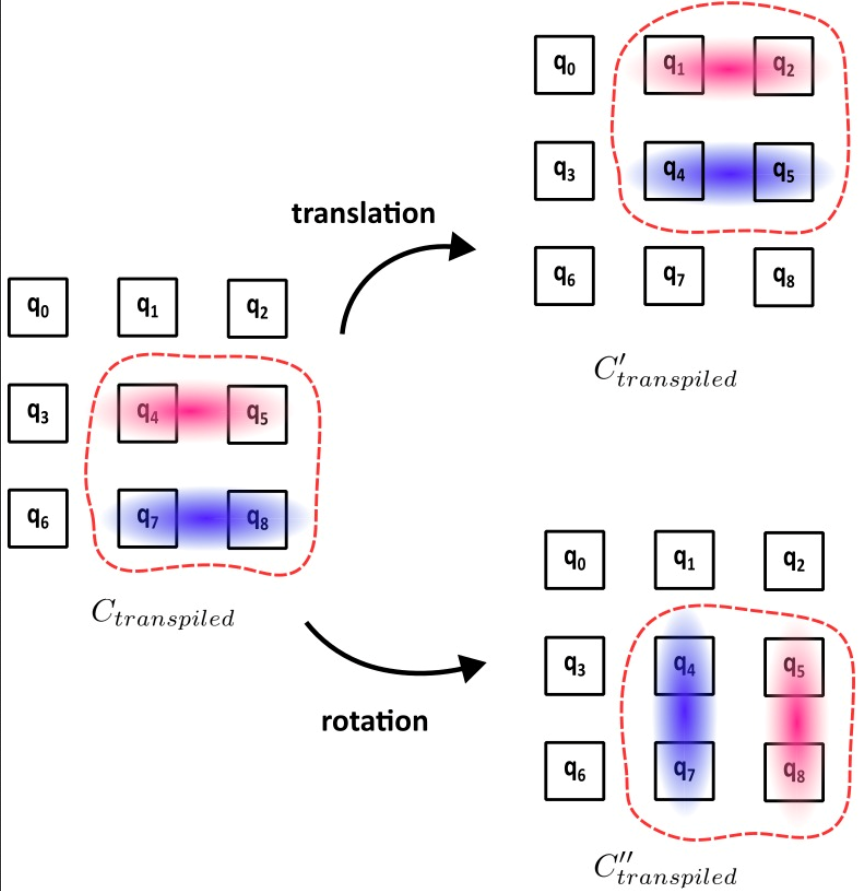

In theory, $C_{transpiled} $ and a transformed circuit $ C'_{transpiled}$ are equivalent, even if one considers typical error models. In fact, error models usually regard all (pairs of connected) qubits on the same footing. However, in practice, the set of gates involved in $C_{transpiled} $ may 'perform', e.g., prepare states, better or worse than the set of gates employed in $C'_{transpiled}$. We then propose the idea of comparing the performance of $C_{transpiled} $ and $ C'_{transpiled}$. We will measure the performance of circuits in terms of the performance of the circuit's two-qubit gates, as these are the main source of error for IBM devices. It is thus essential to quantify the error of the available two-qubit gates that the quantum computer one is using. Assume each pair $(i, j)$ of connected qubits, indicated with $i \sim j$, can undergo one certain two-qubit gate only (e.g., CNOT or ECR). Also, assume that the error $\epsilon_{ij}$ of each two-qubit gate is known. One can then draw a graph where each vertex $i$ represents qubit $i$; (directed) edges $(i,j)$ indicate pairs of connected qubits (going,e.g., from the control qubit to the target qubit in the case of CNOT); and the **thickness** of an edge $(i, j)$ is proportional to the error $\epsilon_{ij}$. 

**Example:** Qiskit-generated connectivity and error graph for the IBM Brisbane quantum computer.

/tmp/ipykernel_22775/357982786.py:10: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


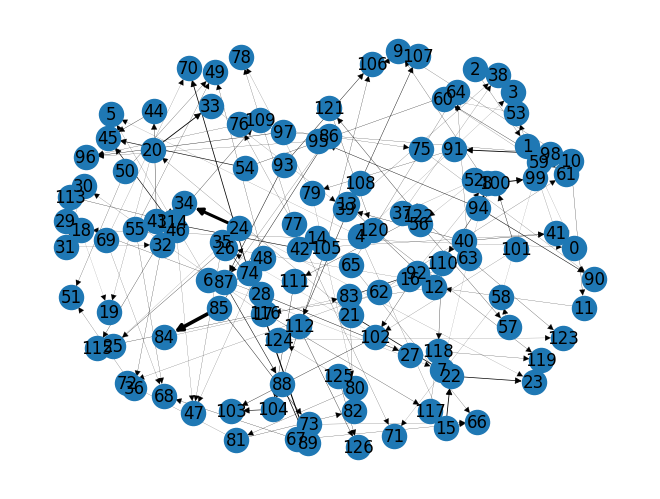

In [24]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import QiskitRuntimeService
import networkx as nx
import numpy as np

#token = #please insert your quantum.ibm.com token here
#QiskitRuntimeService.save_account(channel='ibm_quantum', token = token, instance="ibm-q/open/main", set_as_default=True, overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

two_qubit_gate = "ecr"
conn_qubit_pairs_with_errors = [
        (
            edge[0],
            edge[1],
            backend.properties().gate_error(
                gate = two_qubit_gate, qubits=(edge[0],edge[1])
            ),
        )
        for edge in backend.coupling_map
    ]

G = nx.DiGraph()
for x in conn_qubit_pairs_with_errors:
    G.add_edge(x[0], x[1], weight=x[2])

labels = {node: str(node) for node in G.nodes()}
edges = G.edges()
width_scaling = 20.
weights = [width_scaling * G[u][v]['weight'] for u,v in edges]

nx.draw(G, labels=labels, width = weights)

### 3B) General features of our optimization scheme ###

We propose a **scheme** to optimize the performance of the transpiled circuit over these rotations and translations (and other possible allowed transformations). Our optimization scheme can be applied based on more or less detailed knowledge of the gate errors:
1. Model-specific error knowledge, based on a given quantum computer model (e.g., Brisbane);
2. Unit-specific knowledge of a certain unit of a quantum computer model (assuming many quantum computer units of the same model will be serially commercialized);
3. Unit-specific, time-resolved knowledge, based on a specific unit of a certain model at a certain moment in time.

Our scheme assumes one knows:
- the **hardware error rate** associated with any available two-qubit gate, i.e., the two-qubit connectivity and error graph;
- the **allowed rotations, translations** or more general **transformations** that can be applied to the given transpiled circuit $C_{transpiled}$ to be optimized.
We encode each of these transformations as a **permutation** $\sigma$ of all $N$ qubits of the quantum computer. We call $S_{N}^{allowed}$ the set of the $N$-element permutations $\sigma$ that correspond to allowed transformations of the circuit.

### 3C) The optimization scheme ###

Our scheme acts **after** the qiskit transpilation, allowing for seamless integration and performance enhancement without any need to rewrite qiskit code. Given a possibly already optimized qiskit-transpiled circuit $C_{transpiled}$, our scheme consists of the following **further optimization**: we minimize over all allowed permutations $\sigma \in S^{allowed}_N$ the cost function
\begin{equation}
    F(\sigma) = \sum_{i \sim j} g_{ij}(C^{\sigma}_{transpiled}) \cdot \epsilon_{ij}
\end{equation}
where
- $\sigma \in S_N^{allowed}$ is a permutation corresponding to an allowed transformation of the initial transpiled circuit $C_{transpiled}$;
- the sum is over qubits $i$ and $j$ that are connected in the hardware, denoted with $i \sim j$ ;
- $g_{ij}(C)$ is the number of two-qubit gates involving qubits $i$ and $j$ in the (already transpiled) circuit $C$;
- $C^{\sigma}_{transpiled}$ is the circuit obtained by transforming the initial circuit $C_{transpiled}$ according to $\sigma$;
- $\epsilon_{ij}$ is the error of the two-qubit (e.g., CNOT or ECR) gate, accessible in the hardware, between the connected qubits $i$ and $j$.
The optimal permutation $\sigma_{best} \in S_N^{allowed}$ that minimizes $F(\sigma)$ is then used to further improve the transpiled circuit,
\begin{equation}
    C_{transpiled} \rightarrow C'_{transpiled} = C^{\sigma_{best}}_{transpiled}.
\end{equation}

### 3D) Example ###
Consider a 6-qubit quantum computer made of a 3 x 2 grid, arranged as in the below picture.

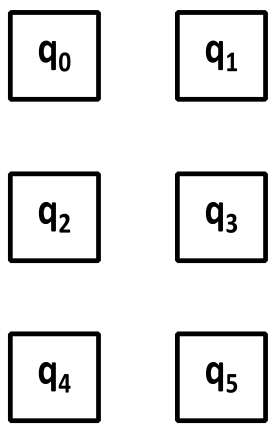

We consider a circuit that creates two Bell pairs (with H + CNOT gates) and later entangles the pairs with one more CNOT gate between the qubits that were target qubits in the first two CNOT gates.

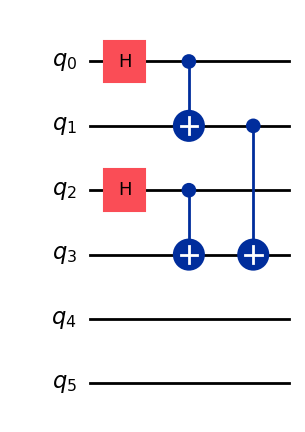

In [25]:
from qiskit import QuantumCircuit
two_bell_circuit = QuantumCircuit(6)

two_bell_circuit.h(0)
two_bell_circuit.cx(0, 1)
two_bell_circuit.h(2)
two_bell_circuit.cx(2, 3)
two_bell_circuit.cx(1, 3)
two_bell_circuit.draw('mpl')

We schematically represent the three CNOT gates of the circuit with the following intuitive picture, where **red** CNOTs are performed before the **blue** cnot:

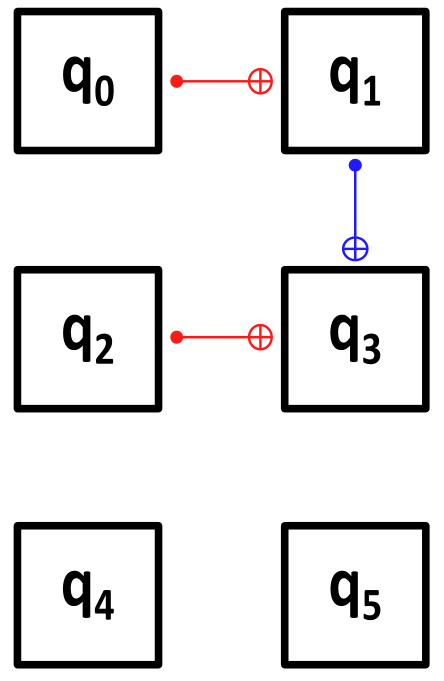


Let us assume that the available quantum computer **is able to perform CNOTs**, so that transpilation will not change the two-qubit gate content (instead, transpilation will decompose the H gates, which is however irrelevant to us). Also, assume the following hardware specifics: all and only pairs of nearest neighbor qubits can undergo a two-qubit gates, with the **lower**-index (leftmost/upper) qubit in the pair being the **control** qubit and the **higher**-index (rightmost/lower) qubit being the **target** qubit (as is the case in the above circuit!). Then, some bookkeeping shows that out of all  6! = 720 permutations $\sigma \in S_6$ of the 6 qubits there are only 5 permutations that belong to the the set $S_6^{allowed}$ of 'allowed' permutations. (This counting includes the identity permutation, and ignores the possible exchange of the two 'idle' qubits, which to be precise would double up the number of allowed permutations to 10.) By that, we mean permutations that correspond to transformations of the circuit that respect the rule set of the hardware, i.e., transformations that map the initial circuit into another circuit that can still be implemented on the hardware, i.e., the CNOTs of the transformed circuit are actually available on the hardware. The 5 corresponding circuits correspond to the following pictures. All other permutations $\sigma \in S_6$ produce a circuit containing a CNOT that cannot be performed on hardware, implying $\sigma \notin S_6^{allowed}$.

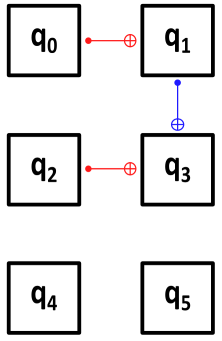    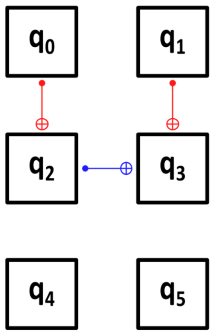 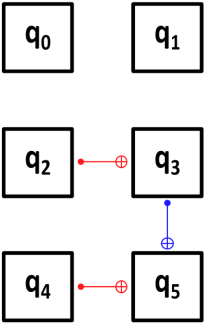 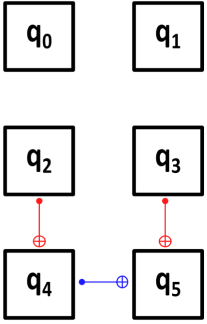 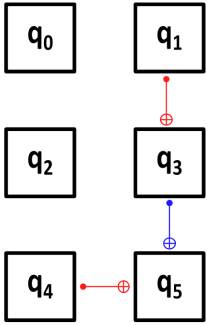

Which of the five schematically represented circuits is the optimal? This depends on the connectivity and error graph of the quantum hardware. We assume that the graph is given by the following, where the edge list 'conn_qubit_pairs_with_errors' is made of 3-tuples $(i, j, \epsilon_{ij})$ (the third entry is the error of the two-qubit gate connecting qubits $i$ and $j$). Remember that each arrow starts from the control qubit and ends at the target qubit of the corresponding gate.

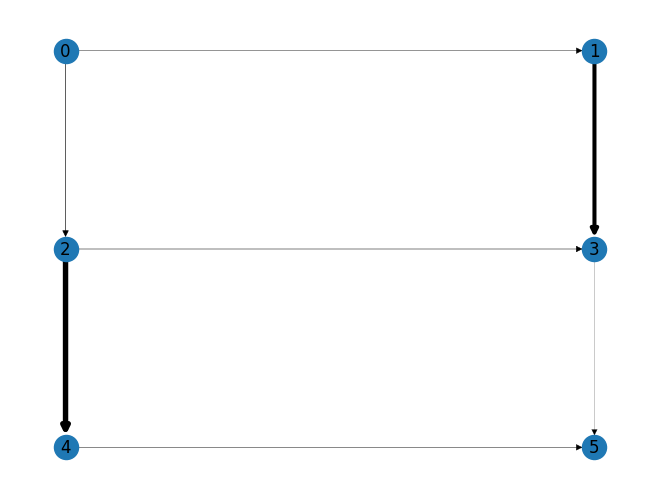

In [26]:
import networkx as nx

conn_qubit_pairs_with_errors = [
        (0,1,0.001),
        (0,2,0.0015),
        (1,3,0.0097),
        (2,3,0.0012),
        (2,4,0.013),
        (3,5,0.0005),
        (4,5,0.0011)
    ]

G = nx.DiGraph()
for x in conn_qubit_pairs_with_errors:
    G.add_edge(x[0], x[1], weight=x[2])
pos = {0: (0, 2), 1: (1, 2), 2: (0, 1), 3: (1, 1), 4:(0,0), 5:(1,0)}

labels = {node: str(node) for node in G.nodes()}
edges = G.edges()
width_scaling = 300.
weights = [width_scaling * G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, labels=labels, width = weights)


In this simple case, it is visually straightforward to see that the optimal circuit among the five ones represented above is the third one. In fact, the only problematic two-qubit gates are the qubit 1-qubit 3 gate and the qubit 2-qubit 4 gate, and among the five circuits the third one is only one which employs neither of these two faulty gates. More formally, one can consider the cost function
\begin{equation}
    F(\sigma) = \sum_{i \sim j} g_{ij}(C^{\sigma}_{transpiled}) \cdot \epsilon_{ij},
\end{equation}
defined over the five allowed permutations
\begin{align}
    \sigma_1 &= (0, 1, 2, 3, 4, 5) \\
    \sigma_2 &= (0, 2, 1, 3, 4, 5) \\
    \sigma_3 &= (2, 3, 4, 5, 0, 1) \\
    \sigma_4 &= (2, 4, 3, 5, 0, 1) \\
    \sigma_5 &= (1, 3, 4, 5, 0, 1)  \\
\end{align}
(we ignore the possible exchange of the two idle qubits). Then the point, as one can check, is that $\sigma_3$ minimizes $F(\sigma)$ over $S^{allowed}_6 = \{ \sigma_1, \sigma_2, \sigma_3, \sigma_4, \sigma_4, \}$. Recall that $g_{ij}(C^{\sigma}_{transpiled})$ is the number of two-qubit gates connecting qubits $i$ and $j$ in the transformed circuit $C^{\sigma}_{transpiled}$. (Also, recall that here the transpilation prior to the application of our scheme is irrelevant because it would not change the number and position of two-qubit gates.)

## 3E) The general case ##

In general, the minimization of the cost function $F(\sigma)$ cannot be performed by just looking at the connectivity and error graph. Instead, it can be done with a general function 'compute_optimal_perm', which we implement below, after introducing some intermediate functions. The function 'compute_optimal_perm' condenses and automatizes our proposed scheme and is thus the main result of this chapter of the notebook.

More in detail, the function 'compute_optimal_perm' takes as input:
- a quantum circuit (already transpiled);
- a list that contains 3-tuples $(i,j, \epsilon_{ij})$, where $(i,j)$ represents an (ordered) pair of connected qubits and $\epsilon_{ij}$ is the unique gate the hardware can apply on them;
and it returns as output a quantum circuit that is obtained by **permuting the qubits in a way that is both optimal with respect to the given errors $\epsilon_{ij}$ and at the same time compatible with the hardware**.
See below for an application to the case of 6 qubits discussed above.

In [27]:
# Here we define the functions needed in 'compute_optimal_perm', which is implemented in the next cell

def perms(N): # returns list of permutations of (0, ..., N-1)
    import itertools
    perms = list(itertools.permutations(range(N)))
    return (perms)

def count_two_qubit_gates_between(qc, q0_index, q1_index): # returns number of two-qubit gates between q0 and q1 in circuit qc
    q0, q1 = qc.qubits[q0_index], qc.qubits[q1_index]
    target_pair = {q0, q1}
    count = 0
    for instr, qargs, _ in qc.data:
        if len(qargs) == 2 and set(qargs) == target_pair:
            count += 1
    return count

def permute_qubits(qc, sigma):
    N = len(sigma)
    assert qc.num_qubits == N, "Permutation size must match number of qubits"

    # Compute the inverse permutation: maps new index to old index
    inverse_sigma = [0] * N
    for i, j in enumerate(sigma):
        inverse_sigma[j] = i

    qc_perm = QuantumCircuit(N, qc.num_clbits)

    for instr, qargs, cargs in qc.data:
        # Use qubits.index(q) to get the index
        new_qargs = [qc_perm.qubits[inverse_sigma[qc.qubits.index(q)]] for q in qargs]
        new_cargs = [qc_perm.clbits[qc.clbits.index(c)] for c in cargs]
        qc_perm.append(instr, new_qargs, new_cargs)

    return qc_perm

def cost_function(count_gates, conn_qubit_pairs_with_errors):
    F = 0.
    for pair_and_err in conn_qubit_pairs_with_errors:
        i  = pair_and_err[0]
        j  = pair_and_err[1]
        err = pair_and_err[2]
        for x in count_gates:
            if (x[0] == i and x[1] == j ) or (x[1] == i and x[0] == j ):
                count = x[2]
                F += count * err
    return F


In [28]:
def compute_optimal_perm(qc, conn_qubit_pairs_with_errors):
    """
    INPUT:
    qc(QuantumCircuit): a (previously transpiled) quantum circuit qc. should already satisfy the hardware requirements
    conn_qubit_pairs_with_errors(List[Tuple[int, int, float]]): a list of 3-tuples (i, j, err). this list is a directed graph containing information on the hardware-available two-qubit gates and their error rates as edge widths. For each 3-tuple (i, j, err), (i,j) is an ordered couple that can undergo a two-qubit gate, with error err
    OUTPUT:
    qc_sigma_best(QuantumCircuit): the optimized circuit, transformed based on the best hardware-allowed permutation sigma_best that minimizes the cost function

    """
    connected_pairs = []
    for x in conn_qubit_pairs_with_errors:
        connected_pairs.append((x[0], x[1]))
        connected_pairs.append((x[1], x[0]))
    N = qc.num_qubits
    sigmas = perms(N)
    count_gates = []
    for i in range(N - 1):
        for j in range(i + 1, N):
            count_gates.append( (i, j, count_two_qubit_gates_between(qc, i, j)) )
    F_min = float('inf')
    sigma_min = sigmas[0] #identity permutation
    for sigma in sigmas:
        perm_count_gates = []
        for x in count_gates:
            perm_count_gates.append((sigma[x[0]], sigma[x[1]], x[2]))
        is_valid_perm = True # check whether permutation is allowed by hardware!
        for x in perm_count_gates: 
            if x[2] != 0 and ( (x[0], x[1]) not in connected_pairs):
                is_valid_perm = False
        if is_valid_perm == True:
            F = cost_function(perm_count_gates, conn_qubit_pairs_with_errors)
        if F < F_min:
            F_min = F
            sigma_min = sigma
        qc_perm = permute_qubits(qc, np.argsort(sigma_min)) # make sure you dont have to invert permutation! i dont think so
    return(qc_perm)


## 3F) Application to 6-qubit circuit

We now apply the general function introduced above to the case of 6 qubits that we treated on an intuitive level before. The result agrees with the intuitive solution, i.e., the optimal and hardware-allowed permutation of the qubits is indeed $\sigma_3 = (2, 3, 4, 5, 0, 1)$. In other words, as expected, the underlying numerical minimization of the cost function confirms that the optimal permutation is the only one that is both allowed by the hardware, and allows us to avoid using the two 'faulty' two-qubit gates. Here is the resulting optimized circuit $C^{\sigma_{best}}_{transpiled}$:

/tmp/ipykernel_22775/4096437175.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in qc.data:
/tmp/ipykernel_22775/4096437175.py:28: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


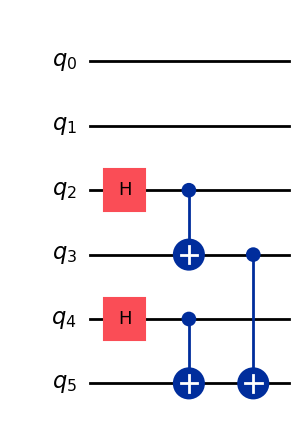

In [29]:
two_bell_circuit_optimal_perm = compute_optimal_perm(two_bell_circuit, conn_qubit_pairs_with_errors)
two_bell_circuit_optimal_perm.draw('mpl')

This circuit indeed corresponds to the circuit representation relative to $\sigma_3$, which we copy here for clarity. (Recall that blue CNOTs are applied after red CNOTs.)


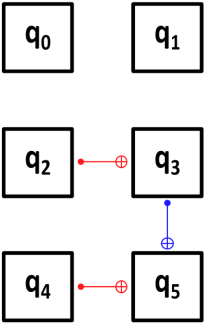
